<a href="https://colab.research.google.com/github/sajith111/Enfit-01/blob/main/Enfit_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import warnings

warnings.filterwarnings("ignore")

import os
import gc
import pickle
import datetime

import numpy as np
import pandas as pd
import polars as pl
import joblib
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
from joblib import load
import seaborn as sns

!pip install optuna
import optuna
from typing import Optional,Dict,Tuple
from pathlib import Path

import holidays
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.1 MB/s eta 0:00:00


In [2]:
# Install Kaggle to download datasets
!pip install kaggle

# Upload your Kaggle API token (kaggle.json)
from google.colab import files
files.upload()

# Create a Kaggle folder and move the kaggle.json file there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Change the permissions of the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
# Download the dataset for the competition
!kaggle competitions download -c predict-energy-behavior-of-prosumers

# Unzip the dataset
!unzip predict-energy-behavior-of-prosumers.zip


100% 233M/233M [00:13<00:00, 20.9MB/s]
100% 233M/233M [00:13<00:00, 18.4MB/s]
Archive:  predict-energy-behavior-of-prosumers.zip
  inflating: client.csv              
  inflating: county_id_to_name_map.json  
  inflating: electricity_prices.csv  
  inflating: enefit/__init__.py      
  inflating: enefit/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: example_test_files/client.csv  
  inflating: example_test_files/electricity_prices.csv  
  inflating: example_test_files/forecast_weather.csv  
  inflating: example_test_files/gas_prices.csv  
  inflating: example_test_files/historical_weather.csv  
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: forecast_weather.csv    
  inflating: gas_prices.csv          
  inflating: historical_weather.csv  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               
  inflating: weather_station_to

In [29]:
data_path = Path('/content/')

train = pd.read_csv(data_path / 'train.csv', parse_dates=['datetime'])

In [30]:
# check datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [31]:
# missing values
train.isna().sum()

,0
county,0
is_business,0
product_type,0
target,528
is_consumption,0
datetime,0
data_block_id,0
row_id,0
prediction_unit_id,0


In [32]:
train = train.dropna(how='any')
train.shape[0]

2017824

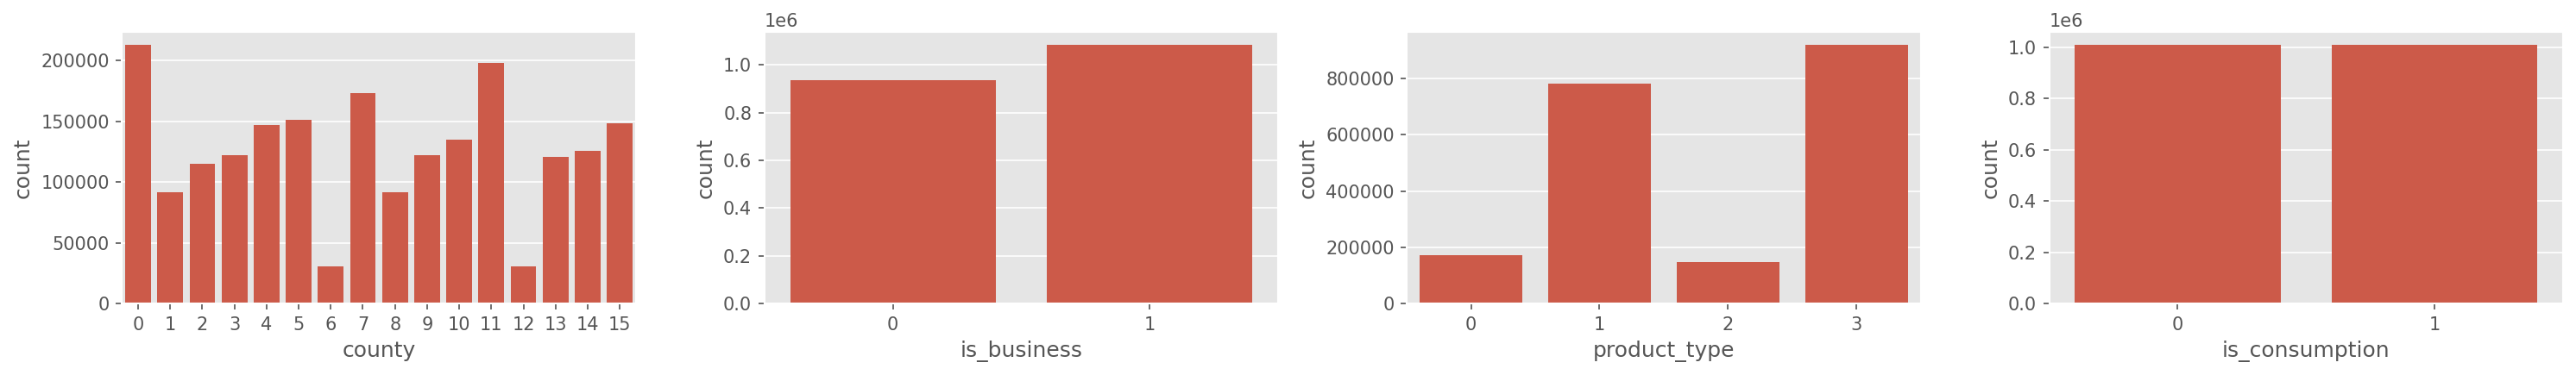

In [33]:
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

for i, column in enumerate(desc_columns):
    _ = sns.countplot(train, x=column, ax=axs[i])

_ = fig.tight_layout()

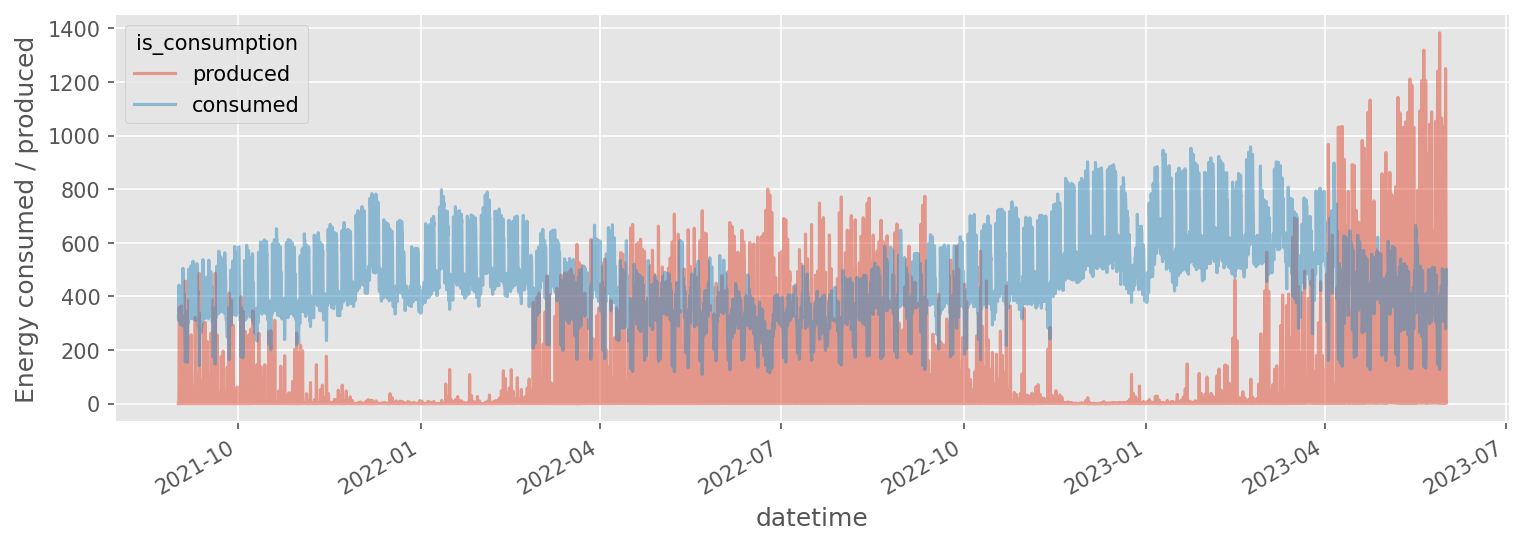

In [34]:
train_avgd = (
    train
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

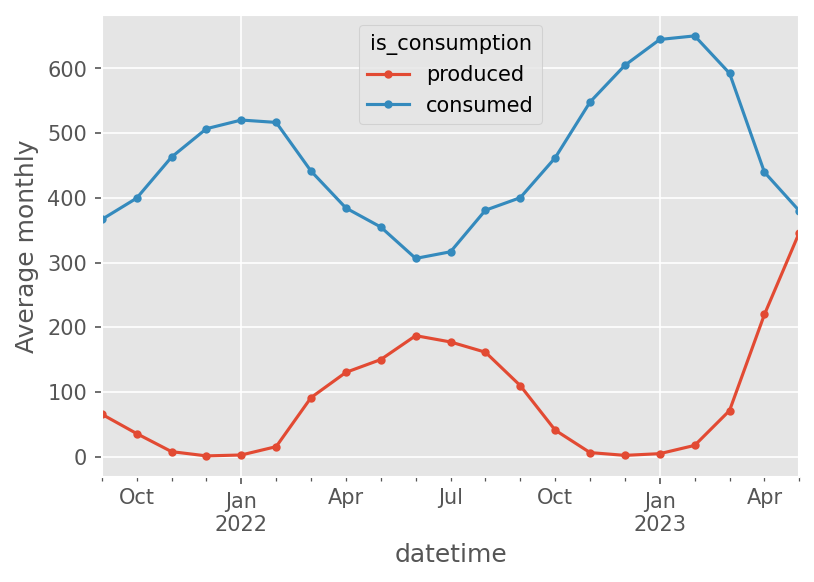

In [35]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

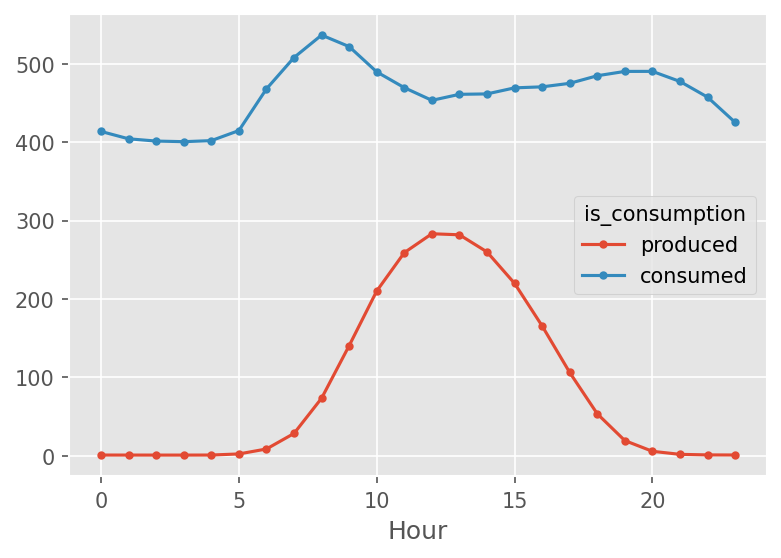

In [36]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

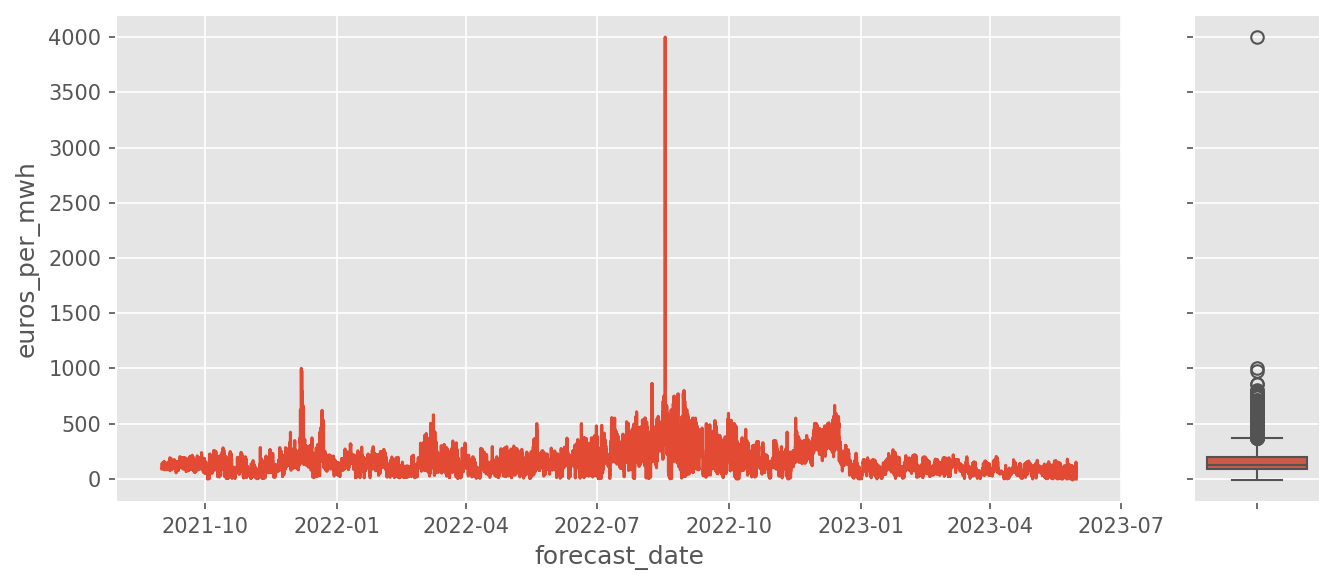

In [37]:
electricity_prices = pd.read_csv(data_path / 'electricity_prices.csv')
electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(electricity_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(electricity_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

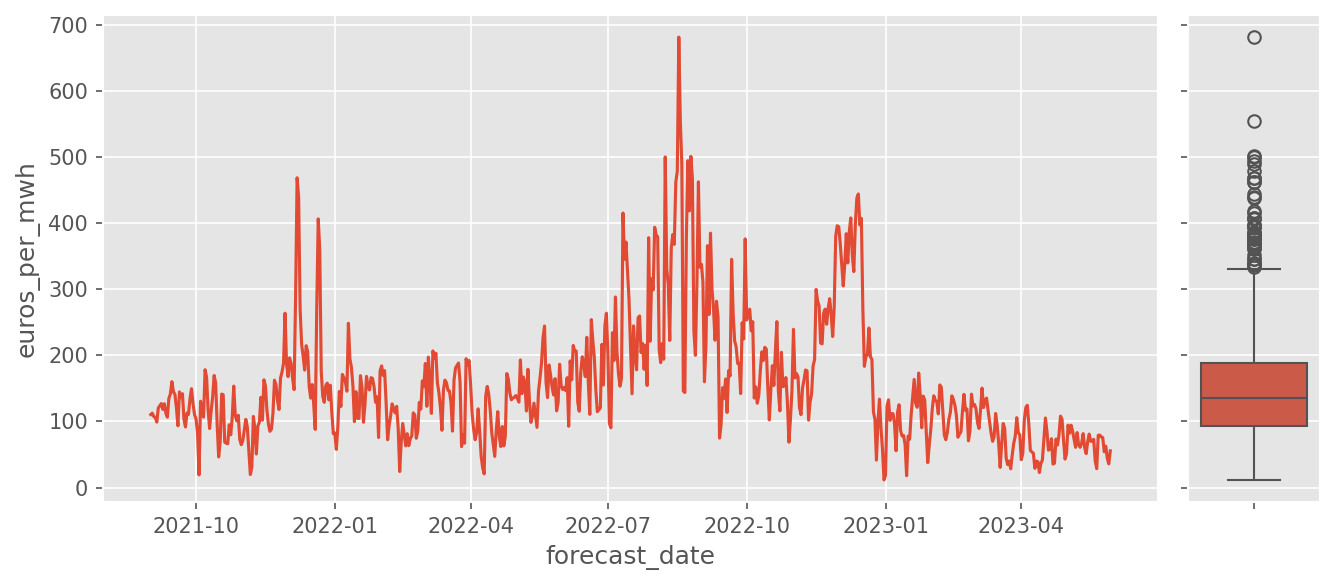

In [38]:
daily_elec_prices = (
    electricity_prices[['forecast_date', 'euros_per_mwh']]
    .set_index('forecast_date')
    .resample('D')
    .mean()
)

fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [8, 1]}, sharey=True)
_ = sns.lineplot(daily_elec_prices, x='forecast_date', y='euros_per_mwh', ax=axs[0])
_ = sns.boxplot(daily_elec_prices, y='euros_per_mwh', ax=axs[1])
#_ = axs[1].get_yaxis().set_visible(False)
fig.tight_layout()

In [39]:
gas_prices =  pd.read_csv(data_path / 'gas_prices.csv')
gas_prices['forecast_date'] = pd.to_datetime(gas_prices['forecast_date'])

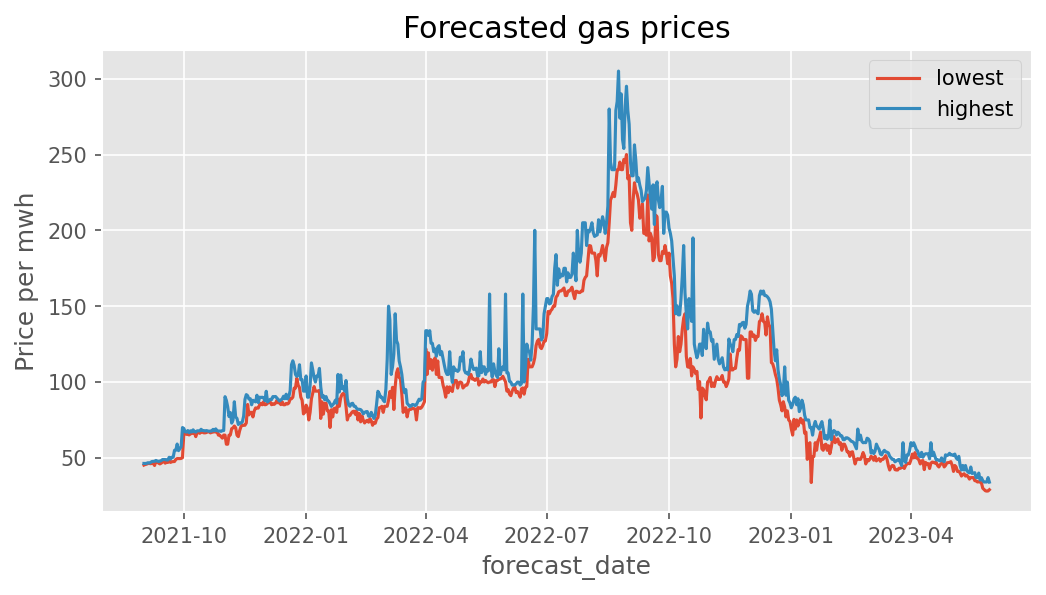

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
_ = sns.lineplot(gas_prices, x='forecast_date', y='lowest_price_per_mwh', ax=ax, label='lowest')
_ = sns.lineplot(gas_prices, x='forecast_date', y='highest_price_per_mwh', ax=ax, label='highest')
_ = ax.legend()
_ = ax.set_ylabel('Price per mwh')
_ = ax.set_title('Forecasted gas prices')

In [41]:
forecast_weather = pd.read_csv(data_path / 'forecast_weather.csv')
historical_weather = pd.read_csv(data_path / 'historical_weather.csv')

# forecast_weather.info()
# historical_weather.info()

In [42]:
forecast_weather.columns = forecast_weather.columns.str.replace('10_metre_', '')

forecast_weather = (
    forecast_weather[forecast_weather['hours_ahead'] > 24]
    .groupby('forecast_datetime')
    .mean(numeric_only=True)
    .reset_index()
)

historical_weather = (
    historical_weather
    .groupby('datetime')
    .mean(numeric_only=True)
    .reset_index()
)

# forecast_weather.info()
# historical_weather.info()

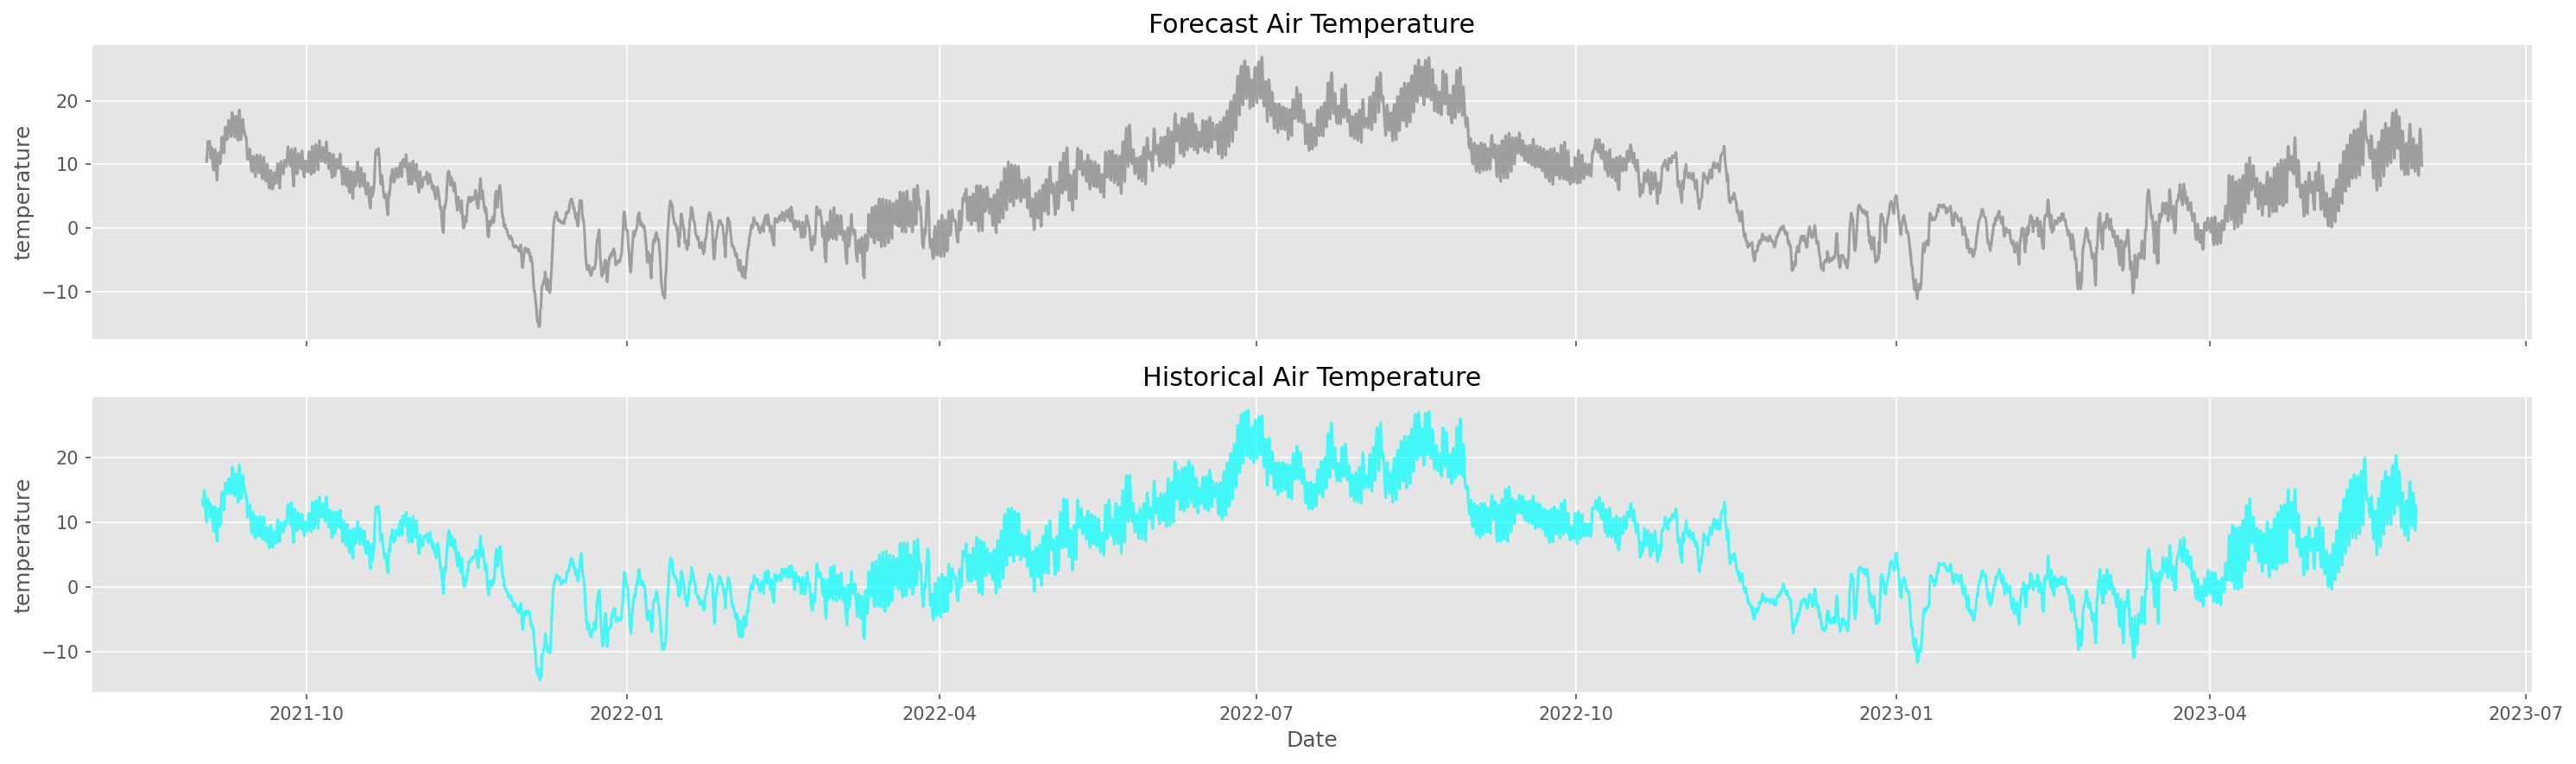

In [43]:
# Convert datetime columns to pandas datetime
forecast_weather['forecast_datetime'] = pd.to_datetime(forecast_weather['forecast_datetime'])
historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])

# Plotting the data
fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

# Plot forecast air temperature
axs[0].plot(forecast_weather['forecast_datetime'], forecast_weather['temperature'], color='grey', alpha=0.7)
axs[0].set_title('Forecast Air Temperature')
axs[0].set_ylabel('temperature')
axs[0].grid(True)

# Plot historical air temperature
axs[1].plot(historical_weather['datetime'], historical_weather['temperature'], color='cyan', alpha=0.7)
axs[1].set_title('Historical Air Temperature')
axs[1].set_ylabel('temperature')
axs[1].grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

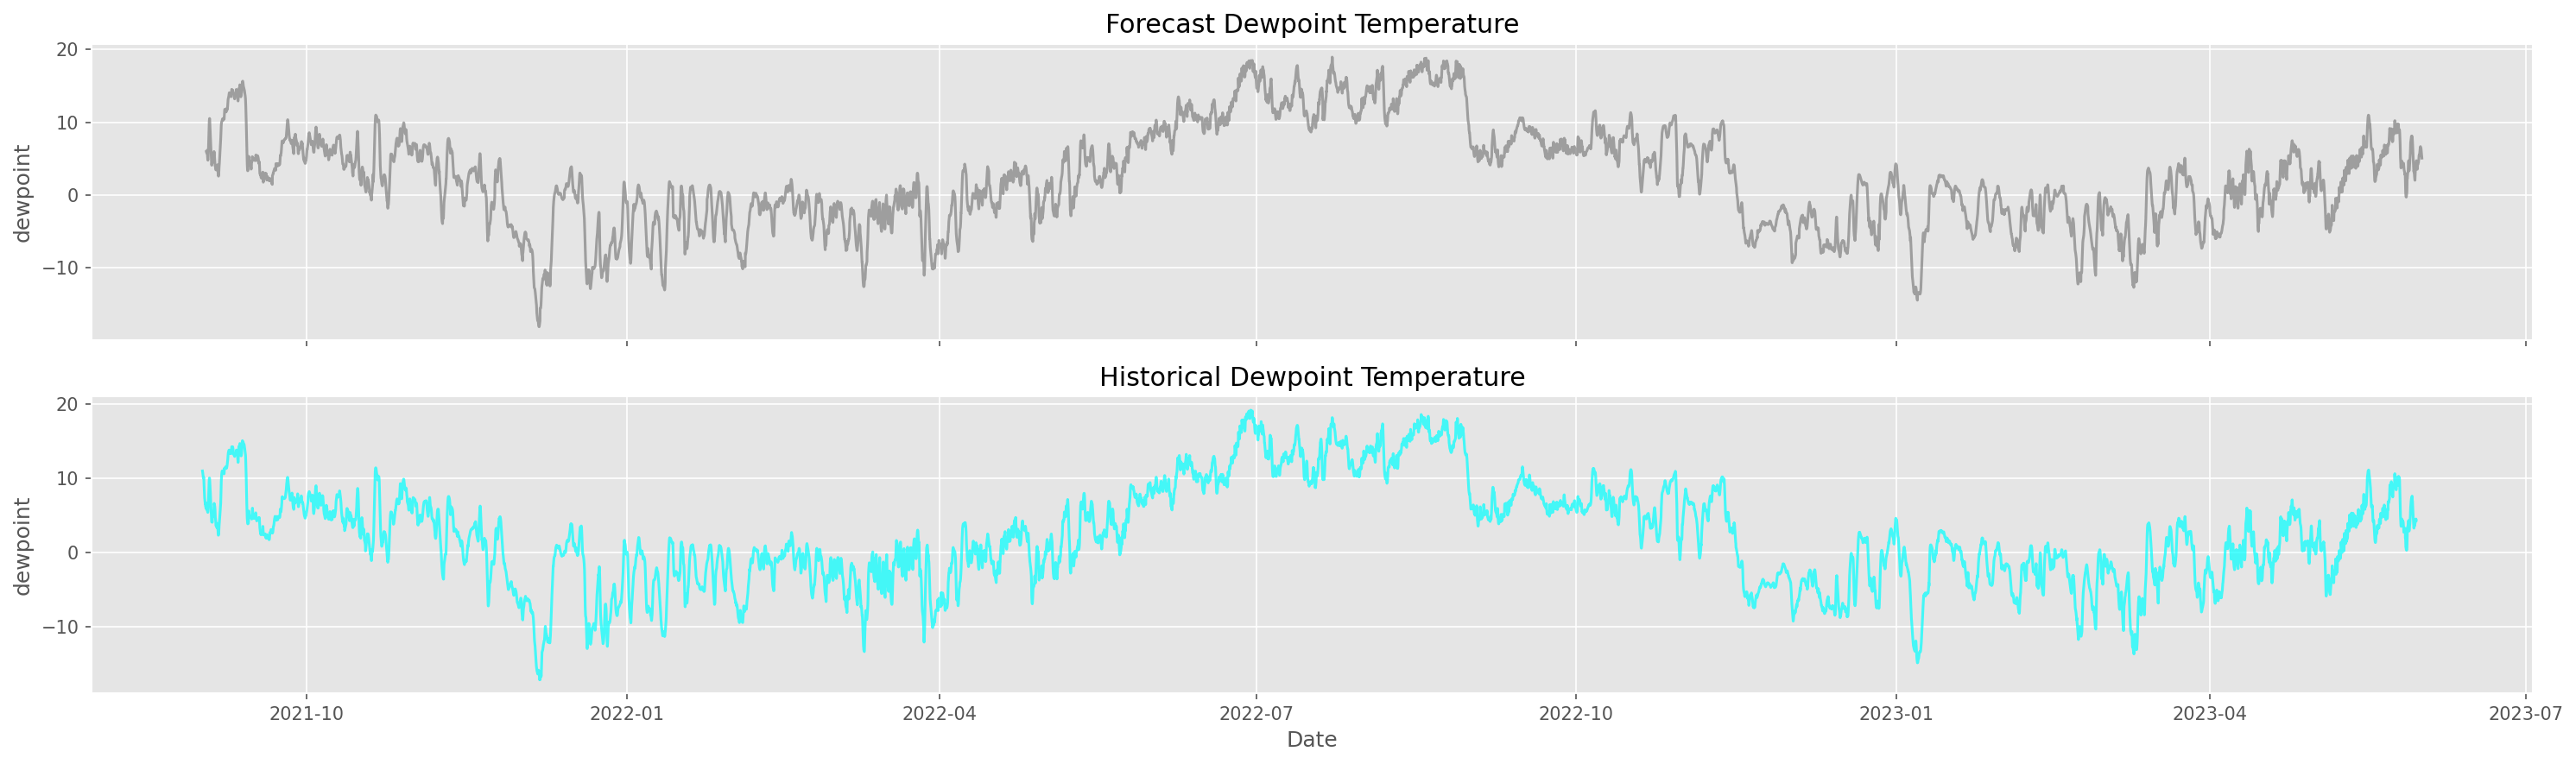

In [44]:
# Plotting the data
fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

# Plot forecast dewpoint temperature
axs[0].plot(forecast_weather['forecast_datetime'], forecast_weather['dewpoint'], color='grey', alpha=0.7)
axs[0].set_title('Forecast Dewpoint Temperature')
axs[0].set_ylabel('dewpoint')
axs[0].grid(True)

# Plot historical dewpoint temperature
axs[1].plot(historical_weather['datetime'], historical_weather['dewpoint'], color='cyan', alpha=0.7)
axs[1].set_title('Historical Dewpoint Temperature')
axs[1].set_ylabel('dewpoint')
axs[1].grid(True)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

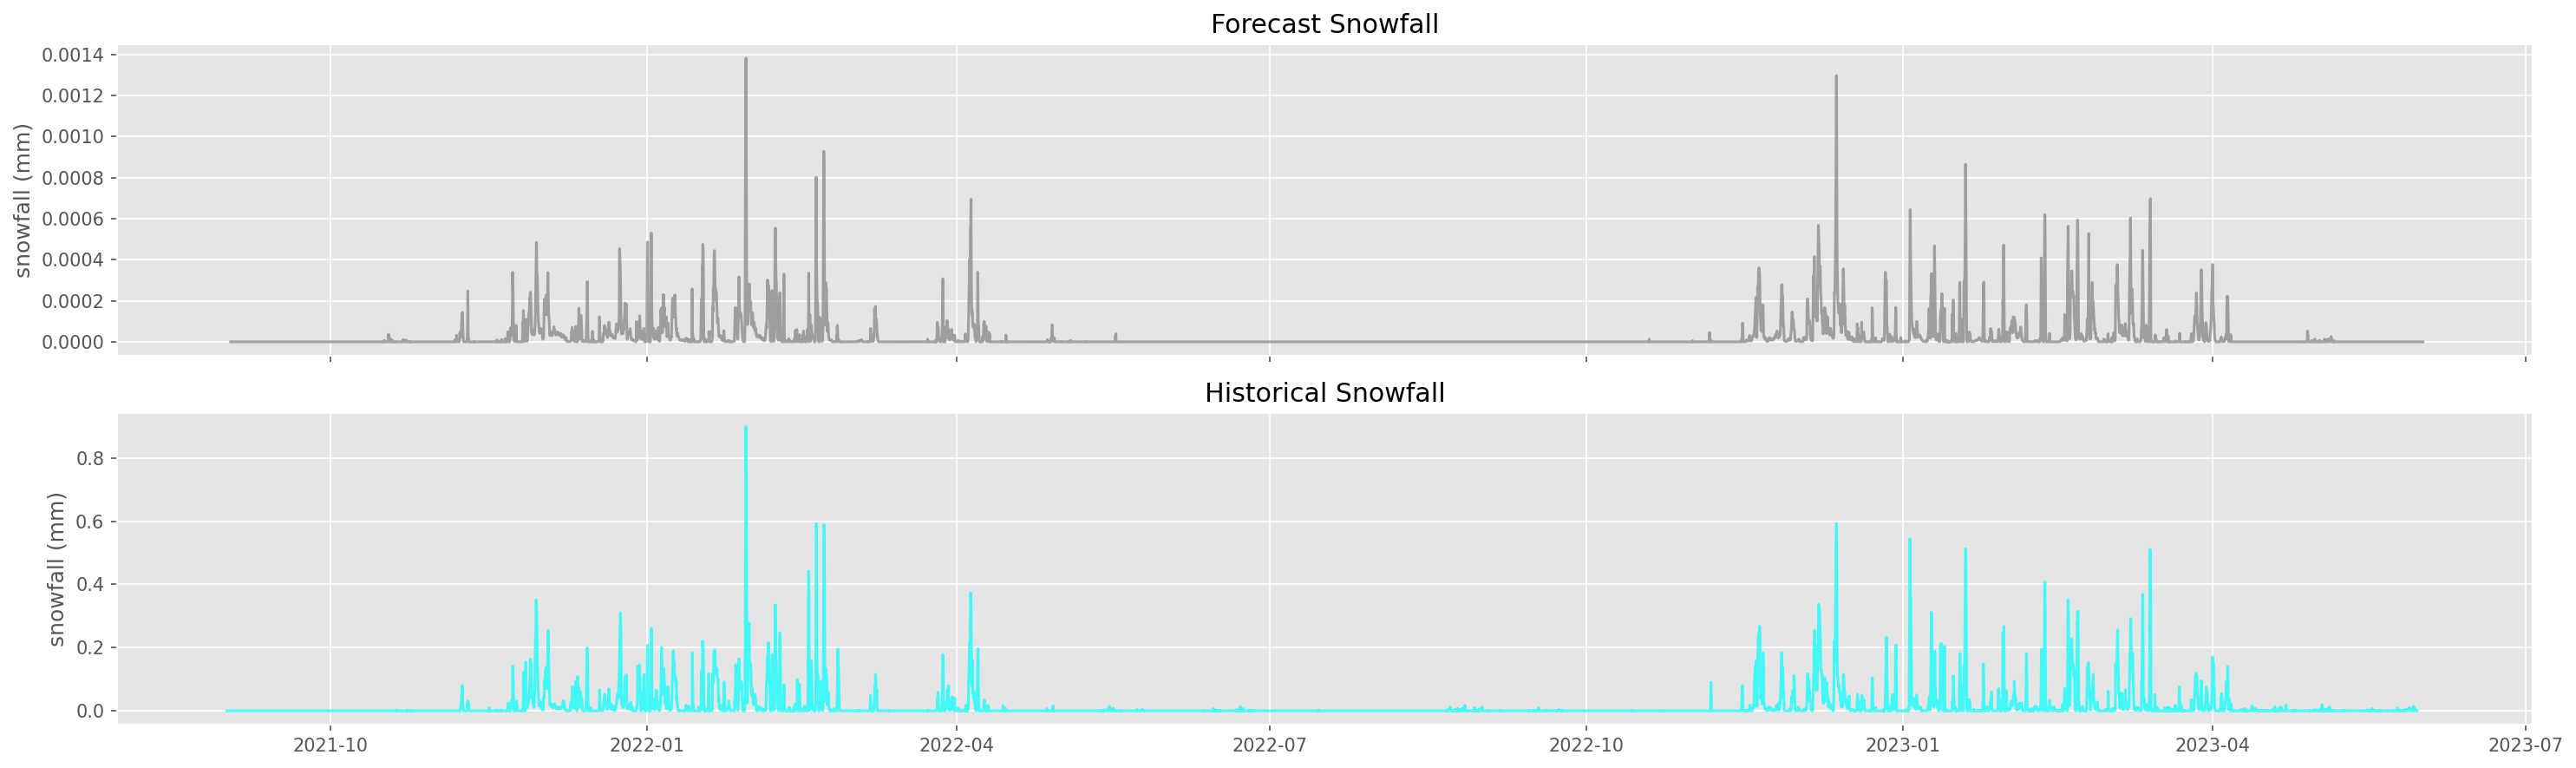

In [45]:
# Plotting the data
fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

# Plot forecast snowfall
axs[0].plot(forecast_weather['forecast_datetime'], forecast_weather['snowfall'], color='grey', alpha=0.7)
axs[0].set_title('Forecast Snowfall')
axs[0].set_ylabel('snowfall (mm)')
axs[0].grid(True)

# Plot historical snowfall
axs[1].plot(historical_weather['datetime'], historical_weather['snowfall'], color='cyan', alpha=0.7)
axs[1].set_title('Historical Snowfall')
axs[1].set_ylabel('snowfall (mm)')
axs[1].grid(True)

# plt.xlabel('Date')
plt.tight_layout()
plt.show()

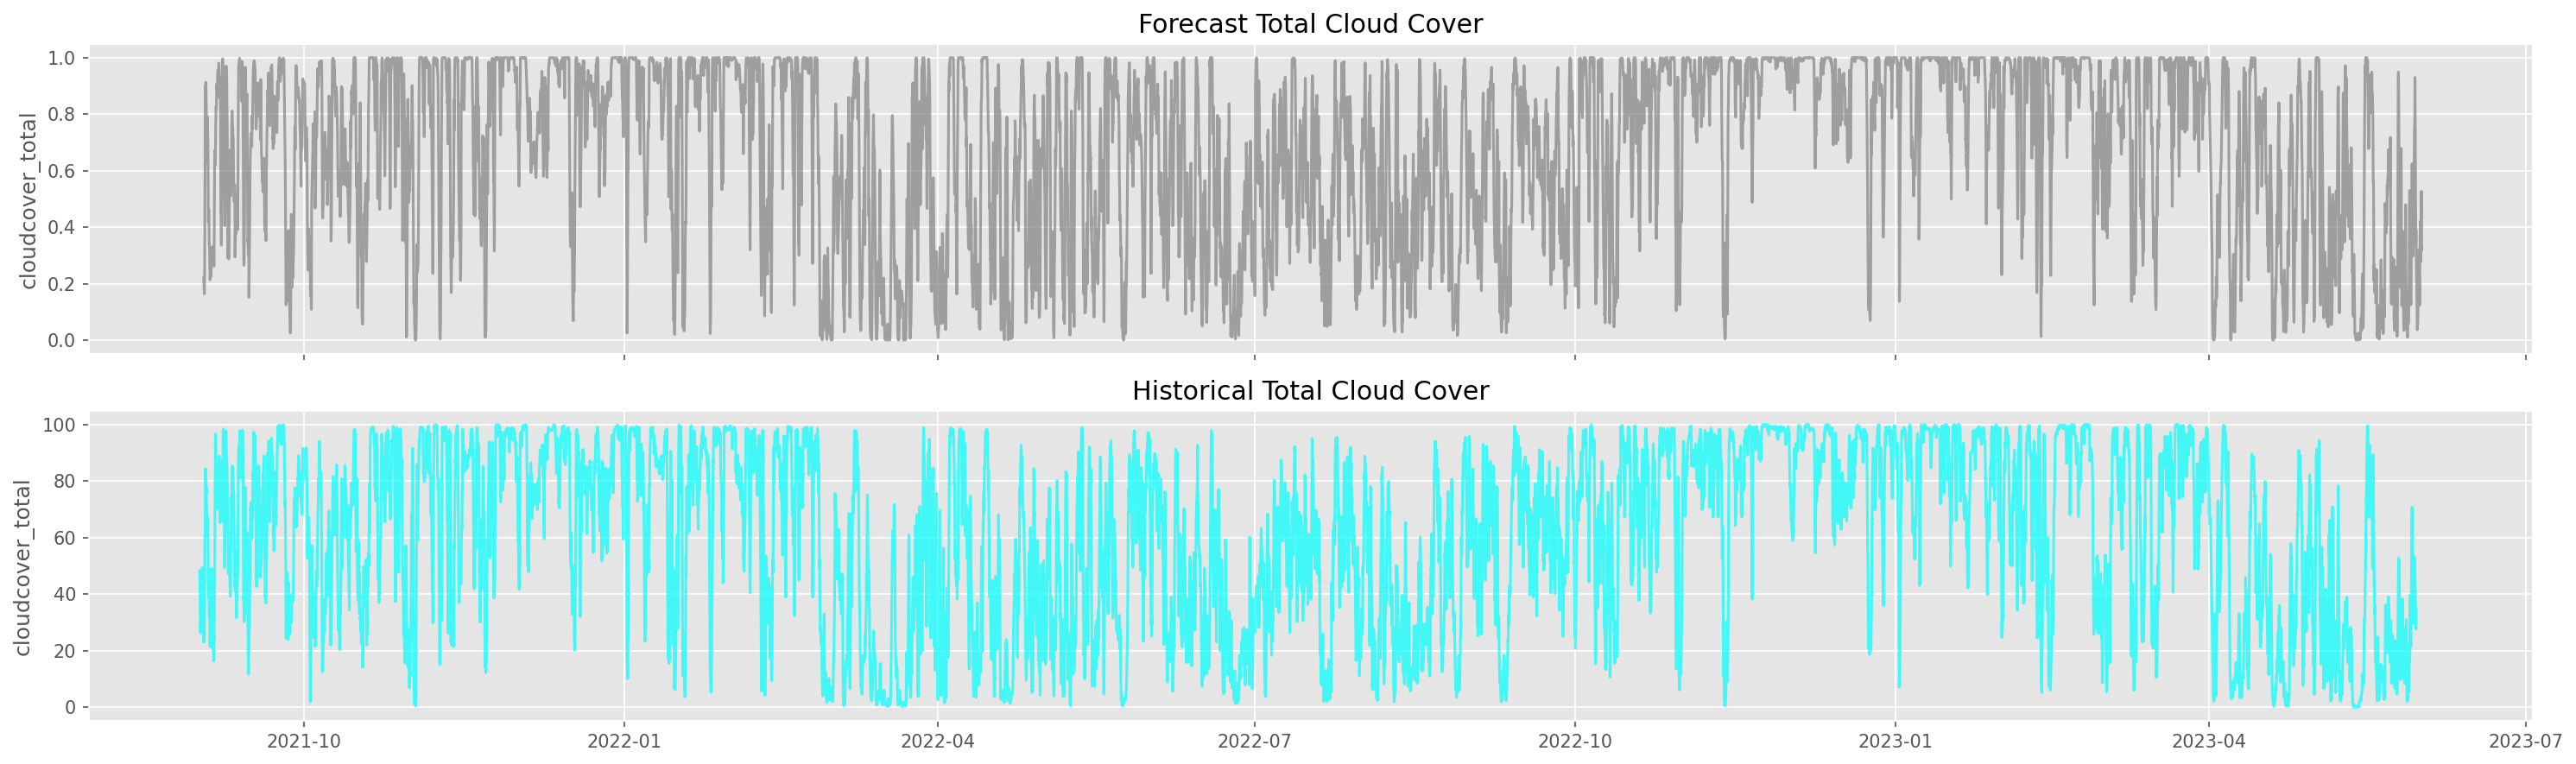

In [46]:
# Plotting the data
fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

# Plot forecast total cloud cover
axs[0].plot(forecast_weather['forecast_datetime'], forecast_weather['cloudcover_total'], color='grey', alpha=0.7)
axs[0].set_title('Forecast Total Cloud Cover')
axs[0].set_ylabel('cloudcover_total')
axs[0].grid(True)

# Plot historical total cloud cover
axs[1].plot(historical_weather['datetime'], historical_weather['cloudcover_total'], color='cyan', alpha=0.7)
axs[1].set_title('Historical Total Cloud Cover')
axs[1].set_ylabel('cloudcover_total')
axs[1].grid(True)

# plt.xlabel('Date')
plt.tight_layout()
plt.show()

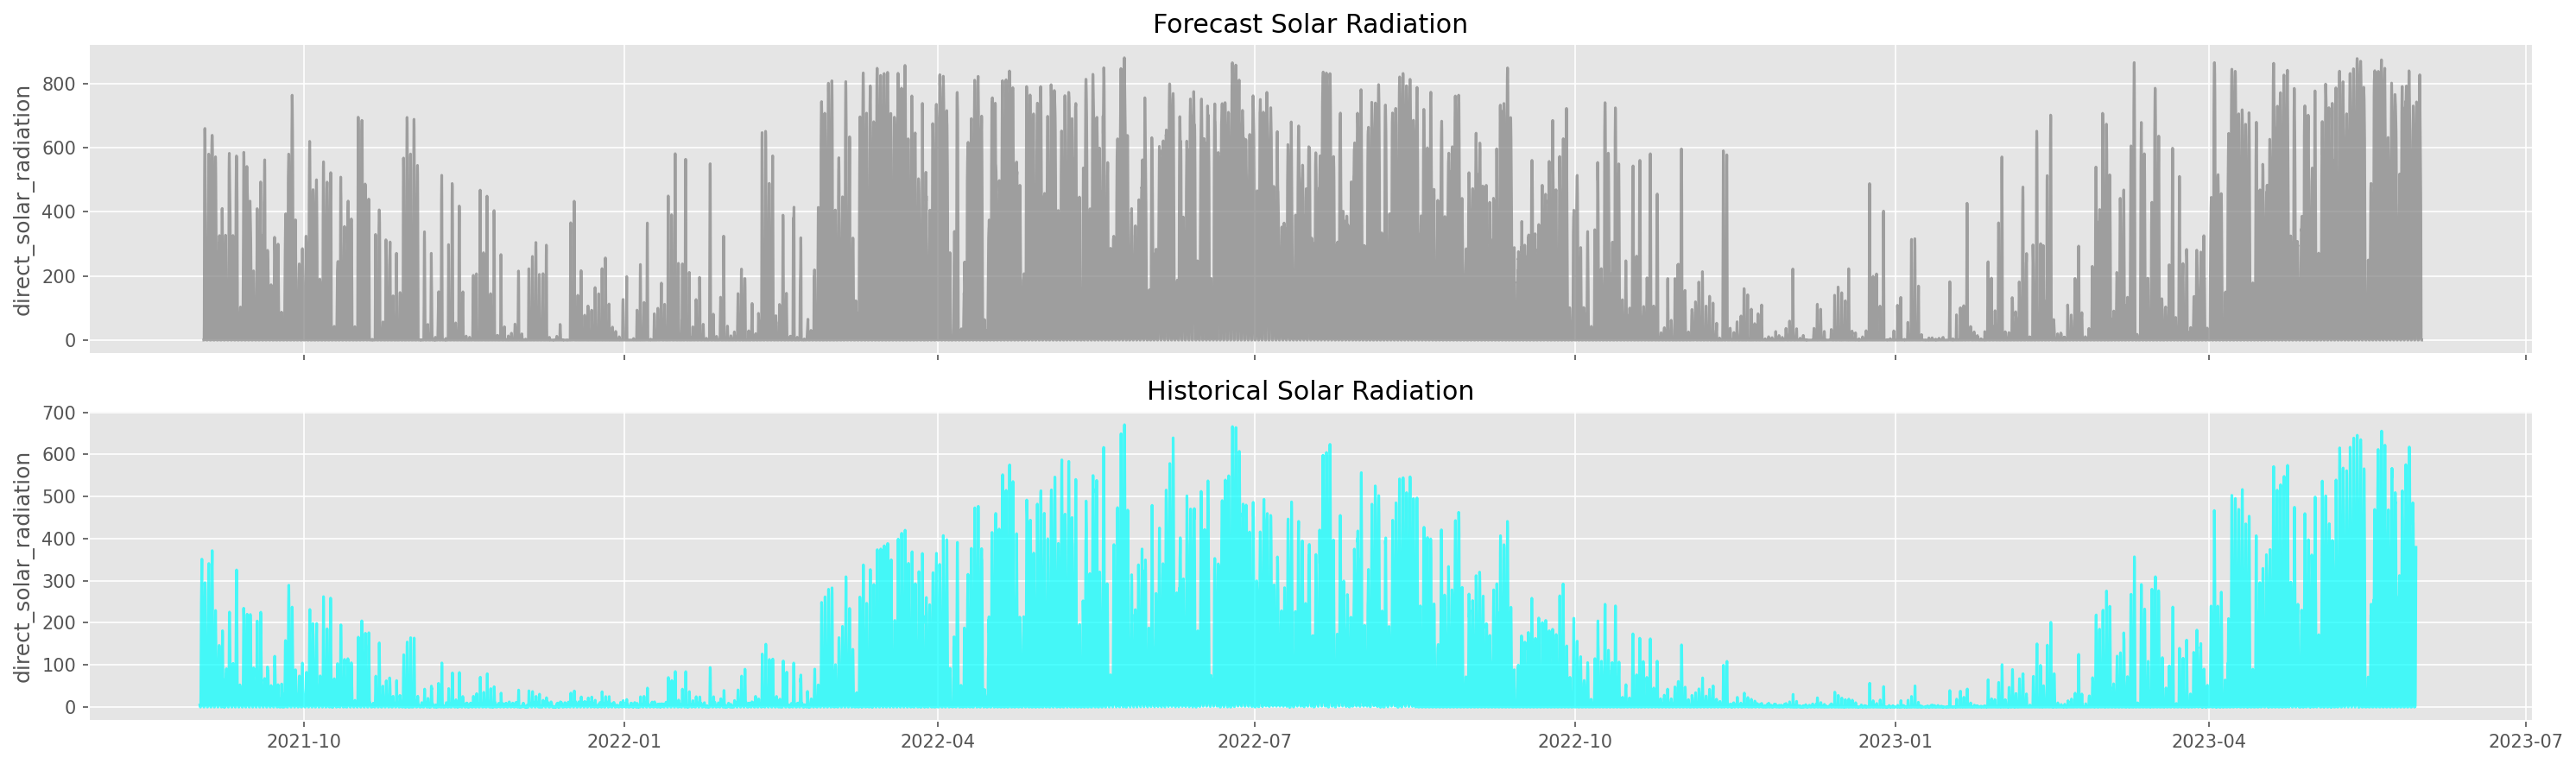

In [47]:
# Plotting the data
fig, axs = plt.subplots(2, 1, figsize=(20, 6), sharex=True)

# Plot forecast total cloud cover
axs[0].plot(forecast_weather['forecast_datetime'], forecast_weather['direct_solar_radiation'], color='grey', alpha=0.7)
axs[0].set_title('Forecast Solar Radiation')
axs[0].set_ylabel('direct_solar_radiation')
axs[0].grid(True)

# Plot historical total cloud cover
axs[1].plot(historical_weather['datetime'], historical_weather['direct_solar_radiation'], color='cyan', alpha=0.7)
axs[1].set_title('Historical Solar Radiation')
axs[1].set_ylabel('direct_solar_radiation')
axs[1].grid(True)

# plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [48]:
class DataStorage:
    root = "/content/"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

In [49]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage
        self.estonian_holidays = list(
            holidays.country_holidays("EE", years=range(2021, 2026)).keys()
        )

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def is_country_holiday(self, row):
        return (
            datetime.date(row["year"], row["month"], row["day"])
            in self.estonian_holidays
        )

    def _add_holidays_features(self, df_features):
        df_features = df_features.with_columns(
            pl.struct(["year", "month", "day"])
            .apply(self.is_country_holiday)
            .alias("is_country_holiday")
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [2 * 24,3 * 24,4 * 24,5 * 24,6 * 24,7 * 24,8 * 24,9 * 24,10 * 24,11 * 24,12 * 24,13 * 24,14 * 24,]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=["county","is_business","product_type","is_consumption","datetime",],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._add_holidays_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [50]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

In [51]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

In [52]:
df_train_features.shape

(1651902, 166)

In [64]:
gc.collect()

146

In [65]:
if('date' in df_train_features.columns):
    df_train_features.drop(columns=['date'], inplace=True)

In [66]:
# print(df_train_features.head(15))

       county is_business product_type is_consumption  day  weekday  month  \
row_id                                                                       
366048      0           0            1              0    1        6      1   
366049      0           0            1              1    1        6      1   
366050      0           0            2              0    1        6      1   
366051      0           0            2              1    1        6      1   
366052      0           0            3              0    1        6      1   
366053      0           0            3              1    1        6      1   
366054      0           1            0              0    1        6      1   
366055      0           1            0              1    1        6      1   
366056      0           1            1              0    1        6      1   
366057      0           1            1              1    1        6      1   
366058      0           1            2              0    1      

In [67]:
train_data = df_train_features.drop(columns=["target"])
train_label = df_train_features["target"]

In [68]:
from sklearn.model_selection import train_test_split
data_train, data_temp, label_train, label_temp = train_test_split(train_data, train_label, test_size=0.3, random_state=42)    #70% train
data_val, data_test, label_val, label_test     = train_test_split(data_temp, label_temp, test_size=0.5, random_state=42)      #15%val - 15%test

In [69]:
label_val1  = label_val.to_numpy()
label_test1 = label_test.to_numpy()
print(label_val1)
print(label_test1)
# label_val.info

[7.49560e+01 3.40926e+02 4.44560e+01 ... 7.97800e+00 2.49900e+01
 3.30000e-01]
[724.691  19.247 315.58  ... 952.205 187.537 334.974]


In [70]:
p1={'n_iter': 1300,'verbose': 1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.08073909898961407,
    'colsample_bytree': 0.726023996436955, 'colsample_bynode': 0.5803681307354022, 'lambda_l1': 6.562963348932286, 'lambda_l2': 3.893256185259296,
    'min_data_in_leaf': 80, 'max_depth': 30, 'max_bin': 1000}

model = lgb.LGBMRegressor(**p1)
model.fit(data_train, label_train, eval_set=[(data_val, label_val), (data_train, label_train)])

results = model.evals_result_

[LightGBM] [Warning] num_iterations is set=1300, n_iter=1300 will be ignored. Current value: num_iterations=1300
[LightGBM] [Warning] lambda_l1 is set=6.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.562963348932286
[LightGBM] [Warning] lambda_l2 is set=3.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.893256185259296
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 is set=3.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.893256185259296
[LightGBM] [Warning] lambda_l1 is set=6.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.562963348932286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.663987 seconds.
You can set `

In [71]:
pred = model.predict(data_val)
mae_val = mean_absolute_error(label_val,pred)
print('Dự đoán trên tập xác thực với mô hình LightGBM: ', pred)
print('LightGBM MAE',mae_val)

[LightGBM] [Warning] min_data_in_leaf is set=80, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=80
[LightGBM] [Warning] lambda_l2 is set=3.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.893256185259296
[LightGBM] [Warning] lambda_l1 is set=6.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.562963348932286
Dự đoán trên tập xác thực với mô hình LightGBM:  [ 89.3514815  318.16359748  48.04046086 ...  -2.63221791  29.16981315
  -2.86407437]
LightGBM MAE 29.334142278520797


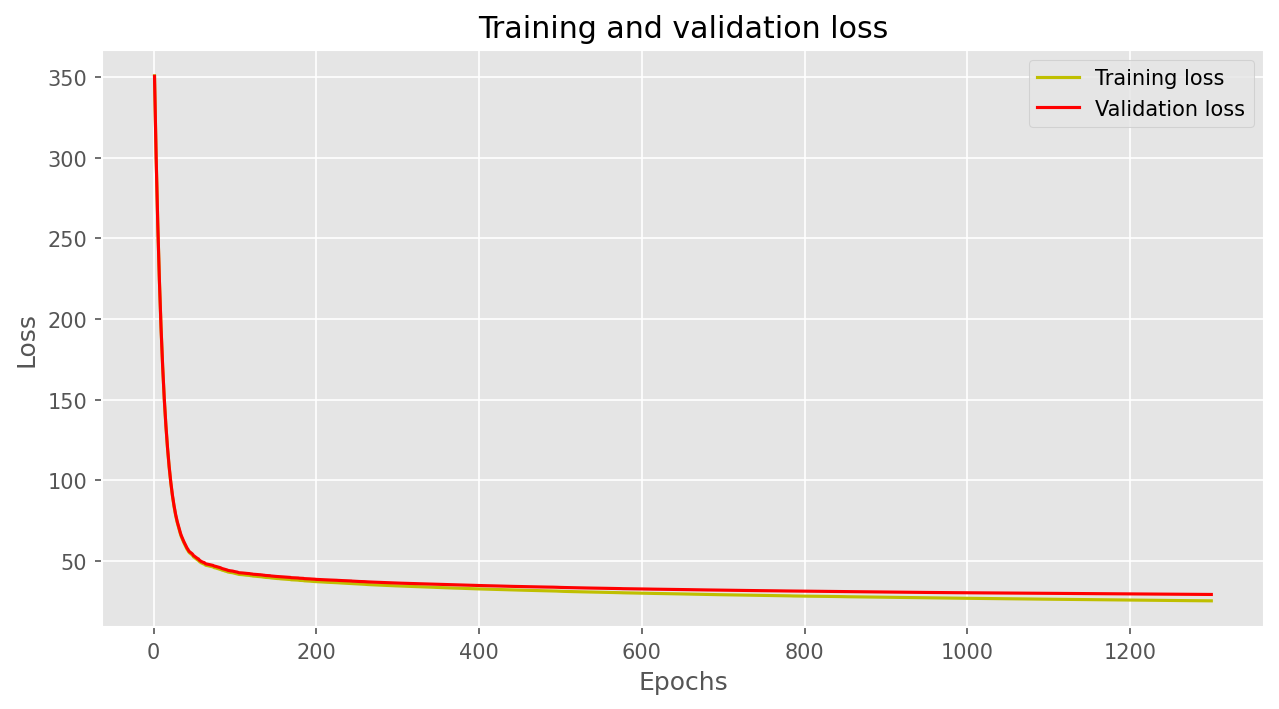

In [72]:
# Chuyển đổi dữ liệu từ dict sang DataFrame để dễ vẽ biểu đồ
history = pd.DataFrame(results['training']['l1'], columns=['train_loss'])
history['val_loss'] = results['valid_0']['l1']
history['epoch'] = range(1, len(history) + 1)

# Vẽ biểu đồ mất mát
plt.figure(figsize=(10, 5))
plt.plot(history['epoch'], history['train_loss'], 'y', label='Training loss')
plt.plot(history['epoch'], history['val_loss'], 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [73]:
#tăng n_iter, giảm learning_rate, tăng lambda, Tăng số lượng min_data_in_leaf, giảm max_depth,max_bin
p1={'n_iter': 2000,'verbose':  1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.05073909898961407,
    'colsample_bytree': 0.726023996436955, 'colsample_bynode': 0.5803681307354022, 'lambda_l1': 8.562963348932286, 'lambda_l2': 4.893256185259296,
    'min_data_in_leaf': 115, 'max_depth': 23, 'max_bin': 898}

model = lgb.LGBMRegressor(**p1)
model.fit(data_train, label_train)

[LightGBM] [Warning] num_iterations is set=2000, n_iter=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.511296 seconds.
You can s

LGBMRegressor(colsample_bynode=0.5803681307354022,
              colsample_bytree=0.726023996436955, lambda_l1=8.562963348932286,
              lambda_l2=4.893256185259296, learning_rate=0.05073909898961407,
              max_bin=898, max_depth=23, metric='mae', min_data_in_leaf=115,
              n_iter=2000, objective='l2', path_smooth=0.02, verbose=1)

In [74]:
pred = model.predict(data_val)
mae_val = mean_absolute_error(label_val,pred)
print('Dự đoán trên tập xác thực với mô hình LightGBM sau khi điều chỉnh tham số: ', pred)
print('LightGBM MAE',mae_val)

[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
Dự đoán trên tập xác thực với mô hình LightGBM sau khi điều chỉnh tham số:  [ 9.38095599e+01  3.34501279e+02  8.86756280e+01 ... -4.15265309e+00
  2.64846710e+01  1.58305173e-01]
LightGBM MAE 28.932088815532556


In [78]:
import os
from joblib import load, dump

ENABLE = True
model_path_consumption = '/content/model-trained/lgbm_model_consumption.joblib'
model_path_production = '/content/model-trained/lgbm_model_production.joblib'

if ENABLE and os.path.exists(model_path_consumption) and os.path.exists(model_path_production):
    lgbm_model_consumption = load(model_path_consumption)
    lgbm_model_production = load(model_path_production)
else:
    lgbm_model_consumption = lgb.LGBMRegressor(**p1, random_state=42)
    lgbm_model_production = lgb.LGBMRegressor(**p1, random_state=42)

    mask = data_train['is_consumption'] == 1
    lgbm_model_consumption.fit(data_train[mask], label_train[mask])
    dump(lgbm_model_consumption, model_path_consumption)

    mask = data_train['is_consumption'] == 0
    lgbm_model_production.fit(data_train[mask], label_train[mask])
    dump(lgbm_model_production, model_path_production)

gc.collect()


[LightGBM] [Warning] num_iterations is set=2000, n_iter=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.919407 seconds.
You can s

4093

In [79]:
def predict_lgbm(data_val):
    predictions = np.zeros(len(data_val))

    mask = data_val["is_consumption"] == 1
    predictions[mask.values] = lgbm_model_consumption.predict(data_val[mask]).clip(0)

    mask = data_val["is_consumption"] == 0
    predictions[mask.values] = lgbm_model_production.predict(data_val[mask]).clip(0)

    return predictions

In [80]:
pred_lgb_val = predict_lgbm(data_val)
mae_lgb_val = mean_absolute_error(label_val1,pred_lgb_val)
print('Dự đoán với 2 mô hình LightGBM: ', pred_lgb_val)
print("LightGBM MAE: ",mae_lgb_val)

[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
Dự đoán với 2 mô hình LightGBM:  [ 77.26853855 323.34165656  14.01221569 ...   4.88187984  26.94748959
   0.86505807]
LightGBM MAE:  24.811174989364154


In [81]:
p2={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.05670084478292278, 'colsample_bytree': 0.6440444070196796, 'colsample_bynode': 0.637635804565811, 'lambda_l1': 6.29090474401462, 'lambda_l2': 6.775341543233317, 'min_data_in_leaf': 95, 'max_depth': 9, 'max_bin': 630}
p3={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.0632167263149817, 'colsample_bytree': 0.6958033941948067, 'colsample_bynode': 0.6030801666196094, 'lambda_l1': 7.137580620471935, 'lambda_l2': 9.348169401713742, 'min_data_in_leaf': 74, 'max_depth': 11, 'max_bin': 530}
p7={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.05689066836106983, 'colsample_bytree': 0.8915976762048253, 'colsample_bynode': 0.5942203285139224, 'lambda_l1': 7.6277555139102864, 'lambda_l2': 6.6591278779517808, 'min_data_in_leaf' : 156, 'max_depth': 11, 'max_bin': 813}

n2={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.06374412210841121, 'colsample_bytree': 0.802532086057236, 'colsample_bynode': 0.6184668009383631, 'lambda_l1': 3.541225815063327, 'lambda_l2': 4.182917449907721, 'min_data_in_leaf': 243, 'max_depth': 20, 'max_bin': 927}
n3={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.050109948518126106, 'colsample_bytree': 0.6614170916069634, 'colsample_bynode': 0.5762169749649555, 'lambda_l1': 9.742269162448217, 'lambda_l2': 4.255738302869081, 'min_data_in_leaf': 76, 'max_depth': 24, 'max_bin': 710}
n4={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.06171183899427052, 'colsample_bytree': 0.677081696428741, 'colsample_bynode': 0.622629956472166, 'lambda_l1': 8.45243483881818, 'lambda_l2': 7.4259913857699225, 'min_data_in_leaf': 56, 'max_depth': 16, 'max_bin': 672}
n5={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.049696057413079676, 'colsample_bytree': 0.7841866462664909, 'colsample_bynode': 0.6395921892446194, 'lambda_l1': 8.366574247816253, 'lambda_l2': 6.23160731836862, 'min_data_in_leaf': 78, 'max_depth': 21, 'max_bin': 889}
n6={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate': 0.050613582357911066, 'colsample_bytree': 0.7381356406195783, 'colsample_bynode': 0.6102298223257949, 'lambda_l1': 9.28925884796848, 'lambda_l2': 6.676852148753467, 'min_data_in_leaf': 86, 'max_depth': 23, 'max_bin': 823}

mx={'n_iter': 2000,'verbose': -1,'objective': 'l2','metric': 'mae','path_smooth': 0.02,'learning_rate':0.057616202767611306, 'colsample_bytree':0.9314998144122667, 'colsample_bynode':0.8001091683962097, 'lambda_l1':7.2392725854842395, 'lambda_l2':7.9043125960594915, 'min_data_in_leaf':85, 'max_depth':14, 'max_bin':687}

In [ ]:
import os
from joblib import load, dump
from sklearn.ensemble import VotingRegressor

# Define the path to the model files
model_path_consumption = '/content/model-trained/voting_model_consumption.joblib'
model_path_production = '/content/model-trained/voting_model_production.joblib'

# Check if ENABLE is True and the model files exist
if ENABLE and os.path.exists(model_path_consumption) and os.path.exists(model_path_production):
    model_consumption = load(model_path_consumption)
    model_production = load(model_path_production)
    gc.collect()
else:
    # Define the voting models for consumption and production
    model_consumption = VotingRegressor([
        ('lgb_0', lgb.LGBMRegressor(**p1, random_state=42)),
        ('lgb_1', lgb.LGBMRegressor(**n2, random_state=42)),
        ('lgb_2', lgb.LGBMRegressor(**mx, random_state=42)),
        ('lgb_3', lgb.LGBMRegressor(**p2, random_state=42)),
        ('lgb_4', lgb.LGBMRegressor(**p3, random_state=42)),
        ('lgb_5', lgb.LGBMRegressor(**n3, random_state=42)),
        ('lgb_6', lgb.LGBMRegressor(**n4, random_state=42)),
        ('lgb_7', lgb.LGBMRegressor(**n5, random_state=42)),
        ('lgb_8', lgb.LGBMRegressor(**p7, random_state=42)),
        ('lgb_9', lgb.LGBMRegressor(**n6, random_state=42)),
    ], weights=[0.14, 0.13, 0.08, 0.11, 0.09, 0.1, 0.09, 0.07, 0.12, 0.07])

    model_production = VotingRegressor([
        ('lgb_10', lgb.LGBMRegressor(**p1, random_state=42)),
        ('lgb_11', lgb.LGBMRegressor(**n2, random_state=42)),
        ('lgb_12', lgb.LGBMRegressor(**mx, random_state=42)),
        ('lgb_13', lgb.LGBMRegressor(**p2, random_state=42)),
        ('lgb_14', lgb.LGBMRegressor(**p3, random_state=42)),
        ('lgb_15', lgb.LGBMRegressor(**n3, random_state=42)),
        ('lgb_16', lgb.LGBMRegressor(**n4, random_state=42)),
        ('lgb_17', lgb.LGBMRegressor(**n5, random_state=42)),
        ('lgb_18', lgb.LGBMRegressor(**p7, random_state=42)),
        ('lgb_19', lgb.LGBMRegressor(**n6, random_state=42)),
    ], weights=[0.14, 0.13, 0.08, 0.11, 0.09, 0.1, 0.09, 0.07, 0.12, 0.07])

    # Train the models
    mask = data_train['is_consumption'] == 1
    model_consumption.fit(data_train[mask], label_train[mask])
    dump(model_consumption, model_path_consumption)

    mask = data_train['is_consumption'] == 0
    model_production.fit(data_train[mask], label_train[mask])
    dump(model_production, model_path_production)

    gc.collect()


[LightGBM] [Warning] num_iterations is set=2000, n_iter=2000 will be ignored. Current value: num_iterations=2000
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] lambda_l1 is set=8.562963348932286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.562963348932286
[LightGBM] [Warning] lambda_l2 is set=4.893256185259296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.893256185259296
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.498845 seconds.
You can s

In [ ]:
def predict_vote(data_val):
    predictions = np.zeros(len(data_val))

    mask = data_val["is_consumption"] == 1
    predictions[mask.values] = model_consumption.predict(data_val[mask]).clip(0)

    mask = data_val["is_consumption"] == 0
    predictions[mask.values] = model_production.predict(data_val[mask]).clip(0)

    return predictions

In [ ]:
pred_vote_val = predict_vote(data_val)
mae_vote_val = mean_absolute_error(label_val1,pred_vote_val)
print("Dự đoán trên tệp xác thực với mô hình VotingRegressor: ", pred_vote_val)
print("VotingRegressor MAE: ",mae_vote_val)

In [ ]:
from catboost import CatBoostRegressor

def preprocess_cat(df):
    df.county = df.county.astype(int)
    df.is_business = df.is_business.astype(int)
    df.product_type = df.product_type.astype(int)
    df.is_consumption = df.is_consumption.astype(int)
    df.segment = df.segment.astype(int)

def fit_cat(train_data,train_label):
    _train_data = train_data.copy()
    task_type = "CPU"
    cat = CatBoostRegressor( colsample_bylevel=0.878, task_type=task_type,
                    reg_lambda=3.438, learning_rate=0.042,
                   max_depth=10, min_data_in_leaf=50,
                    n_estimators=2500,
                            verbose=1,
                   objective='MAE', random_state=1)
    _train_data.county = _train_data.county.astype(int)
    _train_data.is_business = _train_data.is_business.astype(int)
    _train_data.product_type = _train_data.product_type.astype(int)
    _train_data.is_consumption = _train_data.is_consumption.astype(int)
    preprocess_cat(_train_data)
    cat.fit(_train_data,train_label)
    del _train_data
    gc.collect()
    return cat

def predict_cat(_df, cat):
    df = _df.copy()
    preprocess_cat(df)
    prediction = cat.predict(df)
    del df
    gc.collect()
    return prediction

def load_cat():
    with open("/content/model-trained/cat.pickle", "rb") as f:
        return pickle.load(f)

In [ ]:
# cat = fit_cat(data_train,label_train)
# with open("cat.pickle", "wb") as f:
#     pickle.dump(cat, f)

cat = load_cat()

In [ ]:
modelc = CatBoostRegressor(iterations=1000, eval_metric='MAE', early_stopping_rounds=10, verbose=100)
data_test1 = data_test.copy()
data_train1 = data_train.copy()
preprocess_cat(data_test1)
preprocess_cat(data_train1)
modelc.fit(data_train1,label_train, eval_set=(data_test1, label_test), use_best_model=True)
history_cat = modelc.get_evals_result()

In [ ]:
train_loss = history_cat['learn']['MAE']
val_loss = history_cat['validation']['MAE']
epochs = range(1, len(train_loss) + 1)

# Vẽ biểu đồ mất mát
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()

In [ ]:
pred_cat_val = predict_cat(data_val,cat)
mae_cat_val = mean_absolute_error(label_val1,pred_cat_val)

print("Dự đoán trên tệp xác thực với mô hình CatBoost: ",pred_cat_val)
print("CatBoost MAE: ",mae_cat_val)

In [ ]:
def predict_ensemble(data_val):
    predictions = np.zeros(len(data_val))

    mask = data_val["is_consumption"] == 1
    predictions[mask.values] = (
        0.8*model_consumption.predict(data_val[mask]).clip(0) +
        0.2*predict_cat(data_val[mask], cat).clip(0))

    mask = data_val["is_consumption"] == 0
    predictions[mask.values] = (
        0.8*model_production.predict(data_val[mask]).clip(0) +
        0.2*predict_cat(data_val[mask], cat).clip(0))

    return predictions

In [ ]:
pred_ens_val = predict_ensemble(data_val)
mae_ens_val = mean_absolute_error(label_val1,pred_ens_val)

print("Dự đoán trên tệp xác thực với mô hình CatBoost: ",pred_cat_val)
print("Ensemble MAE: ",mae_ens_val)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

In [ ]:
pred_lgb_test = predict_lgbm(data_test)
pred_vote_test = predict_vote(data_test)
pred_cat_test = predict_cat(data_test,cat)
pred_ens_test = predict_ensemble(data_test)

In [ ]:
print("Predict on test data with LightGBM: ",pred_lgb_test)
print("Predict on test data with VotingRegressor: ",pred_vote_test)
print("Predict on test data with CatBoost: ",pred_cat_test)
print("Predict on test data with Ensemble: ",pred_ens_test)

In [ ]:
mae_lgb_test = mean_absolute_error(label_test1,pred_lgb_test)
mae_vote_test = mean_absolute_error(label_test1,pred_vote_test)
mae_cat_test = mean_absolute_error(label_test1,pred_cat_test)
mae_ens_test = mean_absolute_error(label_test1,pred_ens_test)

print("LightGBM MAE: ",mae_lgb_test)
print("VotingRegressor MAE: ",mae_vote_test)
print("CatBoost MAE: ",mae_cat_test)
print("Ensemble MAE: ",mae_ens_test)

In [ ]:
r2_lgb_test  = r2_score(label_test1,pred_lgb_test)
r2_vote_test = r2_score(label_test1,pred_vote_test)
r2_cat_test  = r2_score(label_test1,pred_cat_test)
r2_ens_test  = r2_score(label_test1,pred_ens_test)

print("LightGBM r2_score: ",r2_lgb_test)
print("VotingRegressor r2_score: ",r2_vote_test)
print("CatBoost r2_score: ",r2_cat_test)
print("Ensemble r2_score: ",r2_ens_test)

In [ ]:
mape_lgb_test  = mean_absolute_percentage_error(label_test1,pred_lgb_test)
mape_vote_test = mean_absolute_percentage_error(label_test1,pred_vote_test)
mape_cat_test  = mean_absolute_percentage_error(label_test1,pred_cat_test)
mape_ens_test  = mean_absolute_percentage_error(label_test1,pred_ens_test)

print("LightGBM MAPE: ",mape_lgb_test)
print("VotingRegressor MAPE: ",mape_vote_test)
print("CatBoost MAPE: ",mape_cat_test)
print("Ensemble MAPE: ",mape_ens_test)

In [ ]:
plt.figure()
plt.scatter(label_test1, pred_lgb_test, color='blue', label='LightGBM')
plt.scatter(label_test1, pred_vote_test, color='green', label='VotingRegressor')
plt.scatter(label_test1, pred_cat_test, color='orange', label='CatBoost')
plt.scatter(label_test1, pred_ens_test, color='purple', label='Ensemble')
plt.plot([min(label_test1), max(label_test1)], [min(label_test1), max(label_test1)], color='red', linestyle='--', label='y=x line')


# Thêm nhãn và tiêu đề
plt.xlabel('Test Values')
plt.ylabel('Predict Values')
plt.title('Test vs Predicted Values')

# Thêm chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()